# Federated Learning Reimplementation

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load Dataset

In [3]:
def load_dataset(dataset_name, num_clients, samples_per_client):
    # 1) Load the MNIST or CIFAR10 dataset
    if dataset_name.lower() == 'mnist':
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])

        train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
        test_dataset = datasets.MNIST('./data', train=False, transform=transform)

    elif dataset_name.lower() == 'cifar10':
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

        train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
        test_dataset = datasets.CIFAR10('./data', train=False, transform=transform)

    # 2) Extract two subsets (for 2 clients) without intersection by spliting data
    client_datasets = {}
    indices = torch.randperm(len(train_dataset))
    for k in range(num_clients):
        start_idx = k * samples_per_client
        end_idx = start_idx + samples_per_client
        client_datasets[k] = Subset(train_dataset, indices[start_idx:end_idx])

    return client_datasets, test_dataset

## Create model and update model

In [4]:
# 3) Create a simple Convolutional Neural Network model depending of the dataset
def create_model(dataset_name):
    if dataset_name.lower() == 'mnist':
        return nn.Sequential(
            nn.Conv2d(1, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 5 * 5, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        ).to(device)

    elif dataset_name.lower() == 'cifar10':
        return nn.Sequential(
            nn.Conv2d(3, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 6 * 6, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        ).to(device)

# 4) Create a function average_model_parameters
def average_model_parameters(models, average_weights):
    averaged_params = []

    # Create a zero-filled tensors with the correct size to store the accumulated averages.
    for param in models[0].parameters():
        averaged_params.append(torch.zeros_like(param))

    # Update the averaged parameter by adding the weighted contribution of the current model's parameter
    for model, weight in zip(models, average_weights):
        for avg_param, model_param in zip(averaged_params, model.parameters()):
            avg_param.add_(model_param.data * weight)

    return averaged_params

# 5) Create a function that updates the parameters of a model from a list of values
def update_model_parameters(model, parameters):
    for model_param, new_param in zip(model.parameters(), parameters):
        model_param.data.copy_(new_param)

## Client gestion

In [5]:
# Function that Update the client weights (= update the model of the client)
def client_update(model, dataset, local_epochs, batch_size, learning_rate, dataset_name):
    local_model = create_model(dataset_name)  # Create new instance with same architecture
    local_model.load_state_dict(model.state_dict())

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = optim.SGD(local_model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    local_model.train()
    for _ in range(local_epochs):
        for batch_data, batch_labels in dataloader:
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            optimizer.zero_grad()
            outputs = local_model(batch_data)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

    return local_model

## Evaluate model

In [6]:
# Function that evaluate the model
def evaluate_model(model, test_dataset):
    model.eval()
    test_loader = DataLoader(test_dataset, batch_size=100)
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return 100 * correct / total # accuracy in %

## Federated algorithms and comparaisons

In [7]:
# Function that reproduce algorithm 1 with or without common initialisation
def federated_training(client_datasets, test_dataset, num_rounds, local_epochs, local_batch_size, learning_rate, C, dataset_name ,common_init = False):

    accuracies = []

    # if necessary, initialize a common model
    if common_init:
        global_model = create_model(dataset_name=dataset_name)
    else:
        global_model = None

    selected_clients = list(client_datasets.keys())[:2]  # We use only 2 clients

    for round in range(num_rounds):
        if round == 0 and not common_init:
            client_models = [create_model(dataset_name=dataset_name) for _ in selected_clients]
        else:
            client_models = [
                client_update(
                    model=global_model,
                    dataset=client_datasets[k],
                    local_epochs=local_epochs,
                    batch_size=local_batch_size,
                    learning_rate=learning_rate,
                    dataset_name=dataset_name
                )
                for k in selected_clients
            ]

        # Average with weight 1/2 for each model
        averaged_params = average_model_parameters(models=client_models, average_weights=[0.5, 0.5])

        if global_model is None:
            global_model = create_model(dataset_name=dataset_name)
        update_model_parameters(model=global_model, parameters=averaged_params)

        # Evaluate
        accuracy = evaluate_model(model=global_model, test_dataset=test_dataset)
        accuracies.append(accuracy)

        if (round + 1) % 5 == 0:
            print(f"Round {round+1}/{num_rounds}, Test Accuracy: {accuracy:.2f}%")

    return global_model, accuracies

# 9) Function to see the consequences of reducing the number of data points in each sub-batch
def run_data_points_study(dataset_name, data_points):
    results = {}
    for data_point in data_points:
        print(f"\nTesting data point: {data_point}")
        client_datasets, test_dataset = load_dataset(dataset_name=dataset_name, num_clients=2, samples_per_client=data_point)

        model, accuracies = federated_training(
            client_datasets=client_datasets,
            test_dataset=test_dataset,
            num_rounds=50,
            local_epochs=5,
            local_batch_size=50,
            learning_rate=0.01,
            C=1.0,
            dataset_name=dataset_name,
            common_init=True
        )
        results[data_point] = accuracies[-1]  # Final accuracy
    return results

def execute_all(dataset_name):
    print(f"\nRunning experiments for {dataset_name.upper()}")

    # 1. Load data
    client_datasets, test_dataset = load_dataset(dataset_name=dataset_name, num_clients=2, samples_per_client=600)

    # 7. Train without common initialization
    print("\nTraining without common initialization:")
    model_no_init, acc_no_init = federated_training(
        client_datasets=client_datasets,
        test_dataset=test_dataset,
        num_rounds=50,
        local_epochs=5,
        local_batch_size=50,
        learning_rate=0.01,
        C=1.0,
        dataset_name=dataset_name,
        common_init=False
    )

    # 8. Train with common initialization
    print("\nTraining with common initialization:")
    model_with_init, acc_with_init = federated_training(
        client_datasets=client_datasets,
        test_dataset=test_dataset,
        num_rounds=50,
        local_epochs=5,
        local_batch_size=50,
        learning_rate=0.01,
        C=1.0,
        dataset_name=dataset_name,
        common_init=True
    )

    # Plot comparison
    plt.figure(figsize=(10, 6))
    plt.plot(acc_no_init, label='No common init')
    plt.plot(acc_with_init, label='Common init')
    plt.title(f'FederatedAveraging Performance - {dataset_name.upper()}')
    plt.xlabel('Rounds')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

    # 9. data points study
    data_points = [500, 400, 300, 200, 100]
    data_results = run_data_points_study(dataset_name, data_points)

    # Plot batch size results
    plt.figure(figsize=(10, 6))
    plt.plot(list(data_results.keys()), list(data_results.values()), marker='o')
    plt.title(f'Accuracy vs Data Points - {dataset_name.upper()}')
    plt.xlabel('Data point')
    plt.ylabel('Final Accuracy (%)')
    plt.xscale('log')
    plt.show()


Running experiments for MNIST
Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.57MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 57.7kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:06<00:00, 243kB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 9.88MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw


Training without common initialization:
Round 5/50, Test Accuracy: 80.15%
Round 10/50, Test Accuracy: 88.02%
Round 15/50, Test Accuracy: 90.61%
Round 20/50, Test Accuracy: 91.76%
Round 25/50, Test Accuracy: 92.43%
Round 30/50, Test Accuracy: 92.90%
Round 35/50, Test Accuracy: 93.08%
Round 40/50, Test Accuracy: 93.07%
Round 45/50, Test Accuracy: 93.27%
Round 50/50, Test Accuracy: 93.27%

Training with common initialization:
Round 5/50, Test Accuracy: 89.37%
Round 10/50, Test Accuracy: 91.29%
Round 15/50, Test Accuracy: 92.74%
Round 20/50, Test Accuracy: 93.09%
Round 25/50, Test Accuracy: 93.59%
Round 30/50, Test Accuracy: 93.76%
Round 35/50, Test Accuracy: 93.87%
Round 40/50, Test Accuracy: 93.81%
Round 45/50, Test Accuracy: 93.93%
Round 50/50, Test Accuracy: 93.91%


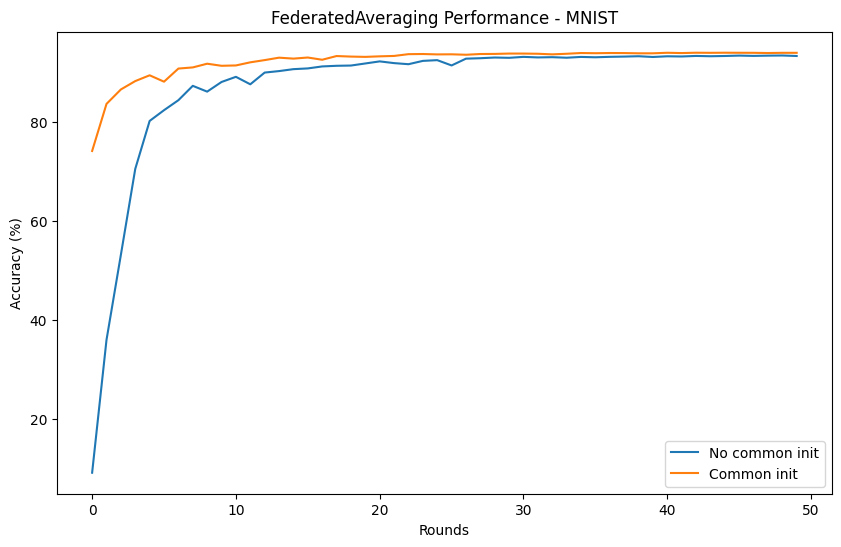


Testing data point: 500
Round 5/50, Test Accuracy: 89.55%
Round 10/50, Test Accuracy: 91.91%
Round 15/50, Test Accuracy: 92.53%
Round 20/50, Test Accuracy: 93.10%
Round 25/50, Test Accuracy: 93.15%
Round 30/50, Test Accuracy: 93.40%
Round 35/50, Test Accuracy: 93.39%
Round 40/50, Test Accuracy: 93.53%
Round 45/50, Test Accuracy: 93.62%
Round 50/50, Test Accuracy: 93.59%

Testing data point: 400
Round 5/50, Test Accuracy: 86.68%
Round 10/50, Test Accuracy: 90.04%
Round 15/50, Test Accuracy: 91.27%
Round 20/50, Test Accuracy: 92.39%
Round 25/50, Test Accuracy: 92.77%
Round 30/50, Test Accuracy: 92.67%
Round 35/50, Test Accuracy: 93.08%
Round 40/50, Test Accuracy: 93.37%
Round 45/50, Test Accuracy: 93.47%
Round 50/50, Test Accuracy: 93.40%

Testing data point: 300
Round 5/50, Test Accuracy: 80.07%
Round 10/50, Test Accuracy: 88.28%
Round 15/50, Test Accuracy: 89.08%
Round 20/50, Test Accuracy: 89.89%
Round 25/50, Test Accuracy: 89.51%
Round 30/50, Test Accuracy: 90.34%
Round 35/50, Test 

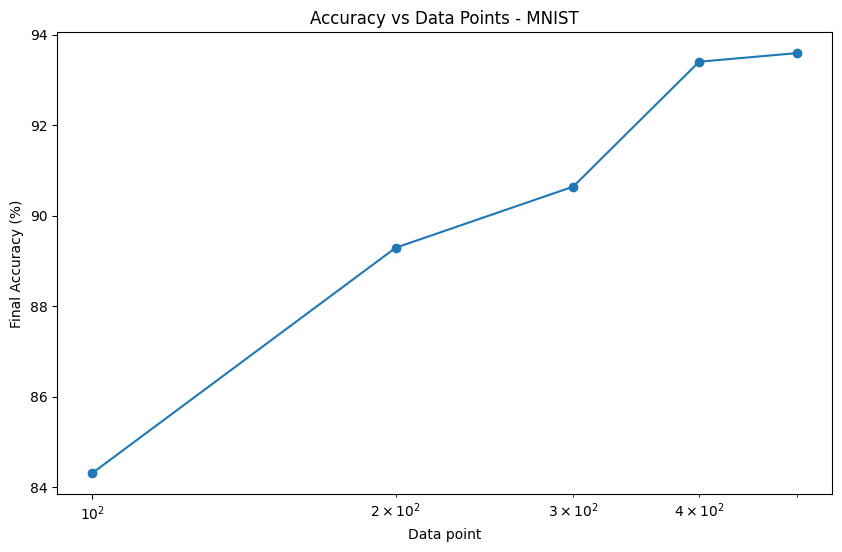

In [8]:
# With MNIST
dataset_name = 'mnist'
execute_all(dataset_name)


Running experiments for CIFAR10


100%|██████████| 170M/170M [00:13<00:00, 12.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data

Training without common initialization:
Round 5/50, Test Accuracy: 13.07%
Round 10/50, Test Accuracy: 17.90%
Round 15/50, Test Accuracy: 26.24%
Round 20/50, Test Accuracy: 32.20%
Round 25/50, Test Accuracy: 34.38%
Round 30/50, Test Accuracy: 35.58%
Round 35/50, Test Accuracy: 36.67%
Round 40/50, Test Accuracy: 38.70%
Round 45/50, Test Accuracy: 37.73%
Round 50/50, Test Accuracy: 38.79%

Training with common initialization:
Round 5/50, Test Accuracy: 23.82%
Round 10/50, Test Accuracy: 31.99%
Round 15/50, Test Accuracy: 33.89%
Round 20/50, Test Accuracy: 36.24%
Round 25/50, Test Accuracy: 37.05%
Round 30/50, Test Accuracy: 39.06%
Round 35/50, Test Accuracy: 39.31%
Round 40/50, Test Accuracy: 38.89%
Round 45/50, Test Accuracy: 40.14%
Round 50/50, Test Accuracy: 40.57%


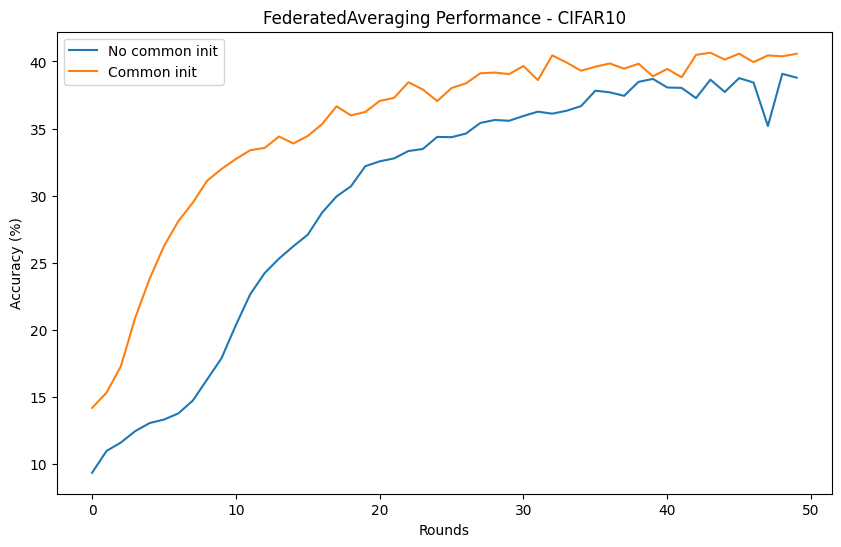


Testing data point: 500
Files already downloaded and verified
Round 5/50, Test Accuracy: 19.15%
Round 10/50, Test Accuracy: 25.86%
Round 15/50, Test Accuracy: 31.38%
Round 20/50, Test Accuracy: 34.36%
Round 25/50, Test Accuracy: 36.87%
Round 30/50, Test Accuracy: 35.52%
Round 35/50, Test Accuracy: 37.64%
Round 40/50, Test Accuracy: 38.28%
Round 45/50, Test Accuracy: 37.86%
Round 50/50, Test Accuracy: 37.60%

Testing data point: 400
Files already downloaded and verified
Round 5/50, Test Accuracy: 21.69%
Round 10/50, Test Accuracy: 28.61%
Round 15/50, Test Accuracy: 32.03%
Round 20/50, Test Accuracy: 33.05%
Round 25/50, Test Accuracy: 34.34%
Round 30/50, Test Accuracy: 34.94%
Round 35/50, Test Accuracy: 34.96%
Round 40/50, Test Accuracy: 35.41%
Round 45/50, Test Accuracy: 33.47%
Round 50/50, Test Accuracy: 34.27%

Testing data point: 300
Files already downloaded and verified
Round 5/50, Test Accuracy: 19.36%
Round 10/50, Test Accuracy: 23.78%
Round 15/50, Test Accuracy: 28.12%
Round 20/

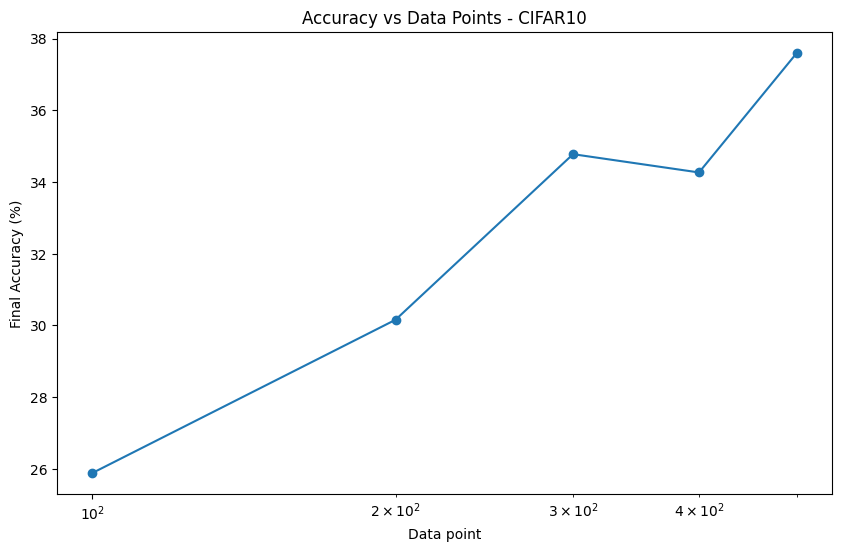

In [9]:
# 9) We do the same with CIFAR10
dataset_name = 'cifar10'
execute_all(dataset_name)